In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
# import cupy as cp
import time

import os

import glob

import LGTp as lgt

In [29]:
N = 8
run_n = 3
dim = 4
# beta_id = "b080to120s40"
# beta_id = "b080to300s20"
# beta_id = 'b010to250s40'
beta_id = "b50to250s40"
# beta_id = "b100to400s40" # 3d
measure_id = "U1-%dr%d"%(N,run_n)+beta_id
n_core = os.cpu_count()
n_core = 4
print(n_core)

4


In [30]:
work_dir = "./"
data_dir = work_dir+"/data/conf/U1/%dd/run%d/U1-%d/"%(dim,run_n,N)+beta_id+'/'
measure_dir = data_dir+"/measure/"
plot_dir = data_dir+"/plots/"

os.system('mkdir -p '+measure_dir)
os.system('mkdir -p '+plot_dir)

u1 = lgt.Lattice([N,N,N,N])
u1.init_fields('U1','Cold')
bare_args = u1.bare_parameter_generator()
g = lgt.action(u1,bare_args)

In [31]:
data_dir

'.//data/conf/U1/4d/run3/U1-8/b50to250s40/'

In [32]:
# beta_list = np.linspace(0.95,1.05,20)
# beta_list = np.linspace(0.80,1.20,40)

In [33]:
def argsort(a,b,c):
    indices = a.argsort()
    return a[indices], b[indices], c[indices]

In [34]:
conf_list = glob.glob(data_dir+'/*.npy')
config = []

tac_list = []
beta_list = []

for conf_id in conf_list:
    tac_local = int(conf_id.split('tac')[-1].split('.')[0])
    tac_list.append(tac_local)
    
    beta_local = float(conf_id.split('b')[-1][:5])
    beta_list.append(beta_local)
    
    conf = np.load(conf_id)
    config.append(conf)

beta_list = np.array(beta_list)
tac_list = np.array(tac_list)
config = np.array(config)
beta_list, config, tac_list = argsort(beta_list, config, tac_list)
    
np.shape(config)

(39, 200, 8, 8, 8, 8, 4)

In [35]:
beta_list

array([0.5  , 0.551, 0.603, 0.654, 0.705, 0.756, 0.808, 0.859, 0.91 ,
       0.962, 1.013, 1.064, 1.115, 1.167, 1.218, 1.269, 1.321, 1.423,
       1.474, 1.526, 1.577, 1.628, 1.679, 1.731, 1.782, 1.833, 1.885,
       1.936, 1.987, 2.038, 2.09 , 2.141, 2.192, 2.244, 2.295, 2.346,
       2.397, 2.449, 2.5  ])

In [36]:
tac_list

array([  1,   2,   2,   2,   3,   4,   4,   7,   8,  15,  63,  86,  96,
        84,  58,  61,  82,  63,  89,  96, 109,  68, 117,  71,  84, 105,
       130,  83,  78, 130,  69,  63,  72,  78,  66,  73,  77,  75, 126])

In [37]:
def measure(b):
#     Plq1 = Pol_r1 = Plq2 = 0.
#     Pol_c1 = 0.+0.j
    
    beta = beta_list[b]
    
    Plq = np.zeros(len(config[b]), dtype=np.float64)
    Pol_c = np.zeros(len(config[b]), dtype=np.complex128)
    S = np.zeros(len(config[b]), dtype=np.float64)
    
    for i in range(len(config[b])):
#     for i in range(2):

#         n1 = len(config[b])
#         n2 = n1*n1
        
        Plq_local = g.plaquetteSum_nb(config[b][i])
        Pol_c_local = g.polyakovLoop_nb(config[b][i])
        S_local = g.S_nb(config[b][i])
#         Polya = np.sqrt(Polya_c*np.conj(Polya_c))
#         print(Plaq, Polya_c, Polya)

        Plq[i] = Plq_local
        Pol_c[i] = Pol_c_local
        S[i] = S_local

#         Plq1 += Plaq
#         Pol_r1 += Polya
#         Pol_c1 += Polya_c
#         Plq2 += Plaq*Plaq
        
#     Plq = Plq1/n1
#     C = beta*beta*(Plq2/n1 - Plq1*Plq1/n2)
#     Pol_r = Pol_r1/n1
#     Pol_c = Pol_c1/n1
    
    return b, Plq, Pol_c, S

In [38]:
# test run
start = time.time()
measure(0)
dur = time.time() - start

n_ensem = len(config)
n_core = 4
expected_dur = n_ensem*dur/n_core


print("test run duration : %.5f sec"%(dur))
print("for %d ensemble ~ %d sec ~ %0.3f hour"%(n_ensem,n_ensem*dur,n_ensem*dur/3600.))
print("with %d core, expecting : %0.3f hour"%(n_core, expected_dur/3600.))

test run duration : 1.85271 sec
for 39 ensemble ~ 72 sec ~ 0.020 hour
with 4 core, expecting : 0.005 hour


In [39]:
now = time.ctime(time.time())
expected_end = time.ctime(time.time() + expected_dur)

print("starting at "+now)
print("expected end time : "+expected_end)

p = mp.Pool(n_core)
res = p.map(measure, range(len(beta_list)))
p.close()
p.join()
Plq = []
Pol_c = []
beta = []
S = []
for i, _r in enumerate(res):
    beta_local, Plq_local, Pol_c_local, S_local = _r
    beta.append(beta_local)
    Plq.append(Plq_local)
    Pol_c.append(Pol_c_local)
    S.append(S_local)
    
now = time.ctime(time.time())
print("ended at "+now)

starting at Tue Apr 19 15:13:17 2022
expected end time : Tue Apr 19 15:13:35 2022
ended at Tue Apr 19 15:13:25 2022


In [40]:
beta = np.array(beta, dtype=np.int)
Plq = np.array(Plq, dtype=np.float64)
Pol_c = np.array(Pol_c, dtype=np.complex128)
S = np.array(S, dtype=np.float64)
Pol_r = np.sqrt(Pol_c*Pol_c.conj()).real

In [42]:
beta

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

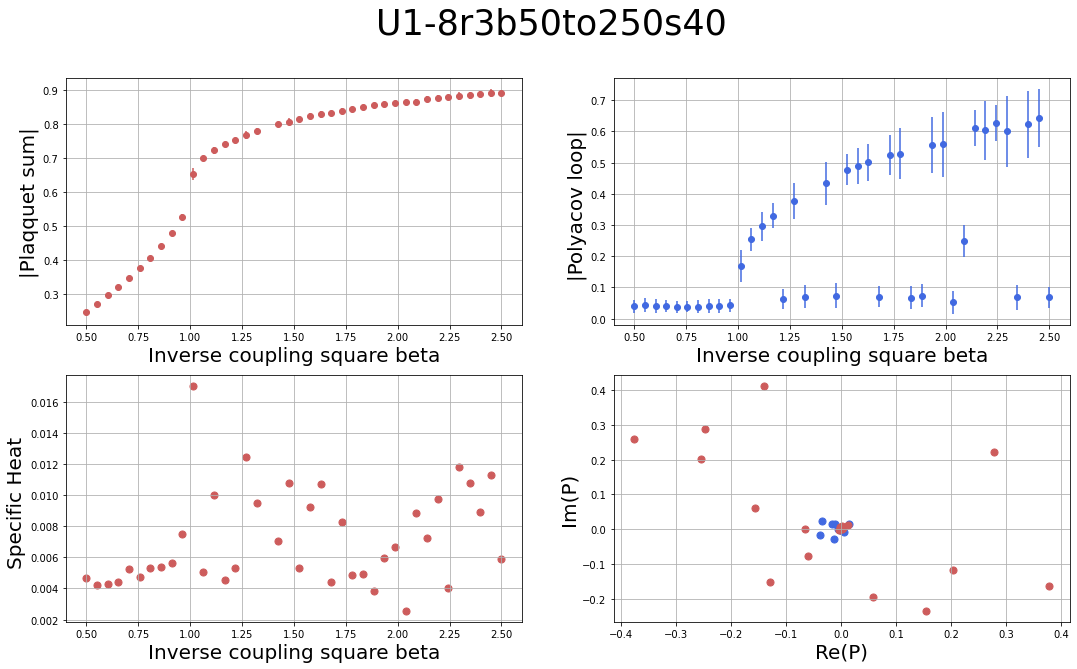

In [41]:
f = plt.figure(figsize=(18, 10)); #  
f.suptitle(measure_id, fontsize=35)

sp =  f.add_subplot(2, 2, 1 );
plt.errorbar(beta_list, np.abs(np.average(Plq,axis=1)), yerr=np.std(Plq,axis=1),fmt='o',c='IndianRed')
plt.xlabel("Inverse coupling square beta", fontsize=20);
plt.ylabel("|Plaqquet sum|", fontsize=20);         plt.axis('tight');
plt.grid(True)


sp =  f.add_subplot(2, 2, 2 );
plt.errorbar(beta_list, np.average(Pol_r,axis=1), yerr=np.std(Pol_r,axis=1),fmt='o',c="RoyalBlue")
# plt.errorbar(beta_list, Pol_r, yerr=M_err, fmt='C0o')
plt.xlabel("Inverse coupling square beta", fontsize=20); 
plt.ylabel("|Polyacov loop| ", fontsize=20);   plt.axis('tight');
plt.grid(True)


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(beta_list, np.std(Plq,axis=1), s=50, marker='o', color='IndianRed')
plt.xlabel("Inverse coupling square beta", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   
plt.grid(True)


sp =  f.add_subplot(2, 2, 4 );
sep_id = int(len(beta_list)/2)
plt.scatter(np.average(Pol_c.real,axis=1)[:sep_id], np.average(Pol_c.imag,axis=1)[:sep_id], s=50, marker='o', color='RoyalBlue')
plt.scatter(np.average(Pol_c.real,axis=1)[sep_id:], np.average(Pol_c.imag,axis=1)[sep_id:], s=50, marker='o', color='IndianRed')
plt.xlabel("Re(P)", fontsize=20); 
plt.ylabel("Im(P)", fontsize=20);   plt.axis('tight');
plt.grid(True)

In [43]:
np.average(Pol_r,axis=1)

array([0.03940416, 0.04303538, 0.04028779, 0.0398784 , 0.03807214,
       0.03837347, 0.03803471, 0.03902066, 0.04027852, 0.04257655,
       0.16837851, 0.25369008, 0.29527667, 0.32959011, 0.0629844 ,
       0.3764301 , 0.06994477, 0.43325629, 0.07377378, 0.47718006,
       0.48943092, 0.50060466, 0.06996254, 0.52369017, 0.52862914,
       0.06635726, 0.07353704, 0.55717892, 0.55910069, 0.05167842,
       0.24854579, 0.61097198, 0.60298663, 0.62684248, 0.60041022,
       0.06852283, 0.62240183, 0.64185478, 0.06836336])

In [46]:
np.average(Pol_r,axis=1)[38]

0.06836336449477938

In [47]:
np.average(Pol_r,axis=1)[30]

0.24854578965525703

In [49]:
np.average(Pol_r,axis=1)[26]

0.07353703955449502

In [53]:
np.average(Pol_r,axis=1)[22]

0.06996253548194742

In [54]:
np.average(Pol_r,axis=1)[18]

0.07377377598486654

In [56]:
np.average(Pol_r,axis=1)[16]

0.06994476693467591

In [57]:
np.average(Pol_r,axis=1)[14]

0.06298440020422025

In [58]:
odd_conf_id = [14,16,18,22,26,30,38]

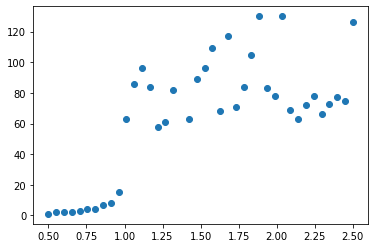

In [59]:
plt.scatter(beta_list,tac_list)

# Save measure

In [60]:
np.savez(measure_dir+measure_id+'.npz',
         beta=beta, 
         Plq=Plq,
         Pol_r = Pol_r,
         Pol_c = Pol_c,
         S = S,
         tac = tac_list,
         odd = odd_conf_id
        )

f.savefig(plot_dir+measure_id+'.png')

In [69]:
a = "b050to200s40"

In [70]:
a.isdigit()

False

In [71]:
for w in a.split():
    print(w)

b050to200s40


In [74]:
a[-2:]

'40'